# <font color="#EA1D2C">Projeto - Análise Exploratória dos Dados (Ada Tech - Ifood)</font>
<hr color="#F5F5F5" size="1">

**Por: [Isadora Mesquita](https://www.linkedin.com/in/isadora-mesquita-895b77190/), [Ingrid Barbosa](https://www.linkedin.com/in/ingridf-abarbosa) e [Eliane Santos](https://www.linkedin.com/in/eliane-analistadedados?utm_source=share&utm_campaign=share_via&utm_content=profile&utm_medium=ios_app)**

<a id='Objetivos fornecidos pelo orientador em documento:'></a>
# <font color="#FFFFFF">Objetivos</font>
<hr color="#F5F5F5" size="1">

A partir de um conjunto de dados (escolhido por vocês ou por sugestão do professor), o objetivo será desenvolver uma análise exploratória dos dados. Para isto segue alguns dos pontos cruciais para o desenvolvimento do projeto:

<br>

- __Definição do Conjunto de Dados:__ Determinar qual conjunto de dados deve ser analisado e se o conjunto de dados atende as espectativas para o projeto;

<br>

- __Análise de Consistência dos Dados__: Verificar se o conjunto de dados tem algum eventual problema (podendo ser dados faltantes, dados erroneos entre outros casos);

<br>

- __Análise Exploratória dos Dados__: Consiste em estudar o conjunto de dados! Então seria entender quais tipos de informações que pode-se obter, quais conclusões e/ou interpretações pode-se tirar dos dados (neste caso, gráfico para auxiliar nas análises são bem vindos).

<br>

__Observações.:__ Este projeto pode ser feito individualmente ou em grupos de no máximo 3 pessoas;

__Data de Entrega:__ 15/03/2024

Fonte do conjunto de dados selecionado: [Kaggle](https://www.kaggle.com/datasets/datacertlaboratoria/projeto-3-segmentao-de-clientes-no-ecommerce/data)

<a id='descricao-variaveis'></a>
# <font color="#EA1D2C"> Metadados:</font>
<hr color="#F5F5F5" size="1">

| Variável | Descrição |
| --- | --- |
| **Nº da fatura** | Um número atribuído exclusivamente a cada transação. Se começar com "c", indica uma substituição (entendemos como devolução). |
| **Data da fatura** | Data e hora da fatura, dia e hora em que a transação foi gerada. |
| **ID Cliente** | Identificação do cliente. Um número integral de 5 dígitos atribuído exclusivamente a cada cliente. |
| **País** | O nome do país onde cada cliente reside. |
| **Quantidade** | As quantidades de cada produto (item) por transação. |
| **Valor** | Valor da fatura de cada cliente em libras esterlinas. |

Buscaremos fazer uso da <strong>Arquitetura Delta</strong>, ensinada brevemente no módulo anterior.

<a id='importar-dataset'></a>
## <font color="#FFFFFF"> Camada BRONZE: Inserção dos dados </font>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import re
import scipy

# Ignora avisos para evitar poluição na saída.
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_bronze = pd.read_csv('vendas-por-fatura.csv')

# Verificar a estrutura
print('O dataset possui', df_bronze.shape[0], 'registros e', df_bronze.shape[1], 'atributos.')

O dataset possui 25953 registros e 6 atributos.


In [3]:
# Visualizando os dados
df_bronze.head()

,N° da fatura,Data da fatura,ID Cliente,País,Quantidade,Valor
0,548370,3/30/2021 16:14:00,15528.0,United Kingdom,123,"229,33"
1,575767,11/11/2021 11:11:00,17348.0,United Kingdom,163,"209,73"
2,C570727,10/12/2021 11:32:00,12471.0,Germany,-1,"-1,45"
3,549106,4/6/2021 12:08:00,17045.0,United Kingdom,1,"39,95"
4,573112,10/27/2021 15:33:00,16416.0,United Kingdom,357,"344,83"


In [4]:
# Verificando informações sobre o DataFrame
print("Informações sobre o DataFrame:")
print(df_bronze.info())

Informações sobre o DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25953 entries, 0 to 25952
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   N° da fatura    25953 non-null  object 
 1   Data da fatura  25953 non-null  object 
 2   ID Cliente      22229 non-null  float64
 3   País            25953 non-null  object 
 4   Quantidade      25953 non-null  int64  
 5   Valor           25953 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.2+ MB
None


<a id='importar-dataset'></a>
## <font color="#FFFFFF"> Camanda SILVER: Tratamento dos dados </font>

In [5]:
# Realizando cópia do df_bronze
df_silver = df_bronze.copy()

In [6]:
# Convertendo a coluna de data para datetime
df_silver['Data da fatura'] = pd.to_datetime(df_silver['Data da fatura'], format='%m/%d/%Y %H:%M:%S')

In [7]:
# Verificando tipo de dado na coluna 'Data da fatura'
df_silver['Data da fatura'].dtype

dtype('<M8[ns]')

In [8]:
# Visualizando o DF
df_silver.head()

,N° da fatura,Data da fatura,ID Cliente,País,Quantidade,Valor
0,548370,2021-03-30 16:14:00,15528.0,United Kingdom,123,"229,33"
1,575767,2021-11-11 11:11:00,17348.0,United Kingdom,163,"209,73"
2,C570727,2021-10-12 11:32:00,12471.0,Germany,-1,"-1,45"
3,549106,2021-04-06 12:08:00,17045.0,United Kingdom,1,"39,95"
4,573112,2021-10-27 15:33:00,16416.0,United Kingdom,357,"344,83"


Dado que as faturas começando com a letra 'C' indicam devoluções e estamos interessados na análise das vendas, optamos por identificar e remover esses registros do nosso conjunto de dados, concentrando nossa análise apenas nas transações de vendas, excluindo os estornos, por enquanto.

O DataFrame devolução foi salvo para futuro estudo.

In [9]:
# Filtrando todas as faturas que começam com 'C'
devolucao = df_silver['N° da fatura'].str.startswith('C')
df_devolucao = df_silver[df_silver['N° da fatura'].str.startswith('C')]

In [10]:
# Verificando a quantidade de dados devolvidos
df_silver[devolucao].shape

(3841, 6)

In [11]:
# Remoção dos dados das compras com devolução
df_silver.drop(df_silver[devolucao].index, inplace=True)

In [12]:
df_silver.head()

,N° da fatura,Data da fatura,ID Cliente,País,Quantidade,Valor
0,548370,2021-03-30 16:14:00,15528.0,United Kingdom,123,"229,33"
1,575767,2021-11-11 11:11:00,17348.0,United Kingdom,163,"209,73"
3,549106,2021-04-06 12:08:00,17045.0,United Kingdom,1,"39,95"
4,573112,2021-10-27 15:33:00,16416.0,United Kingdom,357,"344,83"
5,576630,2021-11-16 08:38:00,13816.0,Germany,91,"199,98"


In [13]:
# Visualizando quantidade de dados restante
df_silver.shape

(22112, 6)

Verificando duplicatas.

In [14]:
# Verificando duplicatas
duplicatas = df_silver.duplicated().sum()
print("Número de duplicatas encontradas:", duplicatas)

Número de duplicatas encontradas: 6


In [15]:
# Removendo duplicatas
df_silver.drop_duplicates(inplace=True)

Verificando e removendo valores nulos.

In [16]:
# Verificando valores nulos
nulos = df_silver.isnull().sum()
print("Quantidade de valores nulos por coluna: \n")
print(nulos)

Quantidade de valores nulos por coluna: 

N° da fatura         0
Data da fatura       0
ID Cliente        3540
País                 0
Quantidade           0
Valor                0
dtype: int64


Há uma enorme quantidade de valores nulos na coluna 'ID CLiente'.

In [17]:
# Visualizando os primeiros valores reconhecidos como nulos
print("\nPrimeiras linhas com valores nulos na coluna 'ID Cliente': \n")
print(df_silver[df_silver['ID Cliente'].isnull()].head())


Primeiras linhas com valores nulos na coluna 'ID Cliente': 

   N° da fatura      Data da fatura  ID Cliente            País  Quantidade  \
11       539736 2020-12-21 15:18:00         NaN  United Kingdom         143   
12       537823 2020-12-08 14:25:00         NaN  United Kingdom        1484   
16       542418 2021-01-27 17:39:00         NaN  United Kingdom         -17   
21       550759 2021-04-20 12:09:00         NaN  United Kingdom          -7   
23       556427 2021-06-10 13:23:00         NaN  United Kingdom          92   

      Valor  
11  1172,46  
12  6073,71  
16     0,00  
21     0,00  
23   435,69  


In [18]:
# Removendo valores nulos
df_silver.dropna(inplace=True)

In [19]:
# Verificando se ainda há valores nulos
print("Quantidade de valores nulos por coluna: \n")
print(df_silver.isnull().sum())

Quantidade de valores nulos por coluna: 

N° da fatura      0
Data da fatura    0
ID Cliente        0
País              0
Quantidade        0
Valor             0
dtype: int64


In [20]:
# Visualizando o novo tamanho do nosso DF
df_silver.shape

(18566, 6)

In [21]:
# Alterando o tipo do dado na coluna 'Valor'
df_silver['Valor'] = df_silver['Valor'].str.replace(',', '.').astype(float)

Será que ainda há quantidade negativa ou menor que um em nossas vendas? Vamos verificar!

In [22]:
def extrair_numero(valor):
    try:
        if int(valor) > 0:
            return int(valor)
        else:
            return None  
    except ValueError:
        return None  

É incoerente que existam elementos com valores menores que um se tratando de quantidade de objetos e de valor. Dito isso, usaremos a função 'extrair_numero' para identificar esses elementos e removê-los.

In [23]:
# Verificando os elementos
df_silver['Quantidade'] = df_silver['Quantidade'].apply(lambda x: extrair_numero(x))
df_silver['Valor'] = df_silver['Valor'].apply(lambda x: extrair_numero(x))
df_silver.head()

,N° da fatura,Data da fatura,ID Cliente,País,Quantidade,Valor
0,548370,2021-03-30 16:14:00,15528.0,United Kingdom,123,229.0
1,575767,2021-11-11 11:11:00,17348.0,United Kingdom,163,209.0
3,549106,2021-04-06 12:08:00,17045.0,United Kingdom,1,39.0
4,573112,2021-10-27 15:33:00,16416.0,United Kingdom,357,344.0
5,576630,2021-11-16 08:38:00,13816.0,Germany,91,199.0


In [24]:
print("Quantidade de valores nulos por coluna: \n")
print(df_silver.isnull().sum())

Quantidade de valores nulos por coluna: 

N° da fatura       0
Data da fatura     0
ID Cliente         0
País               0
Quantidade         0
Valor             12
dtype: int64


In [25]:
dados_none = df_silver[df_silver['Valor'].isnull()]

In [26]:
# Valor máximo e mínimo na coluna 'Quantidade'
print(f"Valor máximo: {max(dados_none['Quantidade'])} e valor mínimo: {min(dados_none['Quantidade'])}")

Valor máximo: 12540 e valor mínimo: 1


Como pode ser observado, há 12 valores nulos na coluna 'Valor', que antes eram iguais ou inferiores a zero, e o maior elemento na coluna 'Quantidade' é 12540. Não há indicação alguma que possa ser um brinde, afinal de contas, faturas diferem de nota fiscal. Por isso, realizaremos a remoção desses valores.

In [27]:
merged_df = df_silver.merge(dados_none, indicator=True, how='outer')
df_silver = merged_df[merged_df['_merge'] == 'left_only'].drop(columns=['_merge'])

In [28]:
# Novo tamanho do Dataset
df_silver.shape

(18554, 6)

Para facilitar a nossa análise temporal, iremos organizar os dados de maneira ascendentes através das datas.

In [29]:
# Ordenando pela Data da Fatura
df_silver.sort_values(by=['Data da fatura'], inplace=True)

Visualizando os dados antes da Camada Gold:

In [30]:
df_silver.head(10)

,N° da fatura,Data da fatura,ID Cliente,País,Quantidade,Valor
6678,536365,2020-12-01 08:26:00,17850.0,United Kingdom,40,139.0
13085,536366,2020-12-01 08:28:00,17850.0,United Kingdom,12,22.0
8014,536368,2020-12-01 08:34:00,13047.0,United Kingdom,15,70.0
4904,536367,2020-12-01 08:34:00,13047.0,United Kingdom,83,278.0
5850,536369,2020-12-01 08:35:00,13047.0,United Kingdom,3,17.0
354,536370,2020-12-01 08:45:00,12583.0,France,449,855.0
9288,536371,2020-12-01 09:00:00,13748.0,United Kingdom,80,204.0
1982,536372,2020-12-01 09:01:00,17850.0,United Kingdom,12,22.0
14641,536373,2020-12-01 09:02:00,17850.0,United Kingdom,88,259.0
17621,536374,2020-12-01 09:09:00,15100.0,United Kingdom,32,350.0


In [31]:
df_silver.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18554 entries, 6678 to 1725
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   N° da fatura    18554 non-null  object        
 1   Data da fatura  18554 non-null  datetime64[ns]
 2   ID Cliente      18554 non-null  float64       
 3   País            18554 non-null  object        
 4   Quantidade      18554 non-null  int64         
 5   Valor           18554 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 1014.7+ KB


<a id='importar-dataset'></a>
## <font color="#FFFFFF"> Camanda GOLD: Análise dos dados | BUSSINES LEVEL AGGREGATE </font>

<a id='analise-metricas'></a>
# <font color="#FFFFFF"> BUSSINES LEVEL AGGREGATE </font>

<div class="alert alert-warning" > 
<strong><div style="color: rgb(234, 29, 44);"> Questões que nos propusemos a responder: :</div></strong> <br>
    <div style="color: rgb(234, 29, 44);">→ Quais países eles atendem? </div>
    <div style="color: rgb(234, 29, 44);">→ Quantos clientes eles possuem? </div>
    <div style="color: rgb(234, 29, 44);">→ Quanto fatura em média (valor) por mês? </div>
    <div style="color: rgb(234, 29, 44);">→ Qual o mês que mais venderam (n° de faturas)? </div>
    <div style="color: rgb(234, 29, 44);">→ Qual o mês que mais venderam (quantidade)? </div>
    <div style="color: rgb(234, 29, 44);">→ Qual a média de venda (quantidade) e faturamento (valor) por país? </div>
    <div style="color: rgb(234, 29, 44);">→ Qual a média de venda (quantidade) e gasto (valor) por cliente? </div>
    <div style="color: rgb(234, 29, 44);">→ Quantos clientes possuem mais de uma compra? </div>
    <div style="color: rgb(234, 29, 44);">→ Qual foi o cliente com maior volume de compras? </div>
    <div style="color: rgb(234, 29, 44);">→ Qual foi o cliente com maior gasto financeiro? </div>


</div>

<div class="alert" > 
<strong><div style="color: rgb(255, 255, 255);"> Gráficos a serem construidos: :</div></strong> <br>
    <div style="color: rgb(255, 255, 255);">→ Gráfico - Quantidade de compras de cada país no ano </div>
    <div style="color: rgb(255, 255, 255);">→ Gráfico - Quantidade de compras de cada país no mês </div>
    <div style="color: rgb(255, 255, 255);">→ Gráfico - Faturamento de compras de cada país no ano </div>
    <div style="color: rgb(255, 255, 255);">→ Gráfico - Faturamento de compras de cada país no mês </div>
    <div style="color: rgb(255, 255, 255);">→ Existe algum horário do dia em que há maior volume de compras? </div>

</div>

In [32]:
# Realizando cópia do df_silver
df_gold = df_silver.copy()
print(f'O dataset possui {df_gold.shape[0]} registros a serem trabalhados.')

O dataset possui 18554 registros a serem trabalhados.


In [33]:
# Visualizar estatísticas descritivas
df_gold.describe().T

,count,mean,min,25%,50%,75%,max,std
Data da fatura,18554,2021-07-01 15:02:15.625741056,2020-12-01 08:26:00,2021-03-30 14:11:45,2021-07-12 14:52:30,2021-10-12 13:26:00,2021-12-09 12:50:00,NaN
ID Cliente,18554.0,15266.178668,12346.0,13777.0,15176.5,16779.0,18287.0,1733.940773
Quantidade,18554.0,278.568018,1.0,74.0,155.0,291.0,80995.0,972.030003
Valor,18554.0,479.823758,1.0,157.0,302.0,471.0,168469.0,1677.104074


### <font color="#FFB761"> 1 - Quais países eles atendem? </font>

In [34]:
# Carregando os dados mundiais
mundo = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Países do mundo que estão presentes no Dataset
countries_to_plot = mundo[mundo['name'].isin(df_gold['País'].unique())]
countries_to_plot = countries_to_plot.sort_values(by='name')

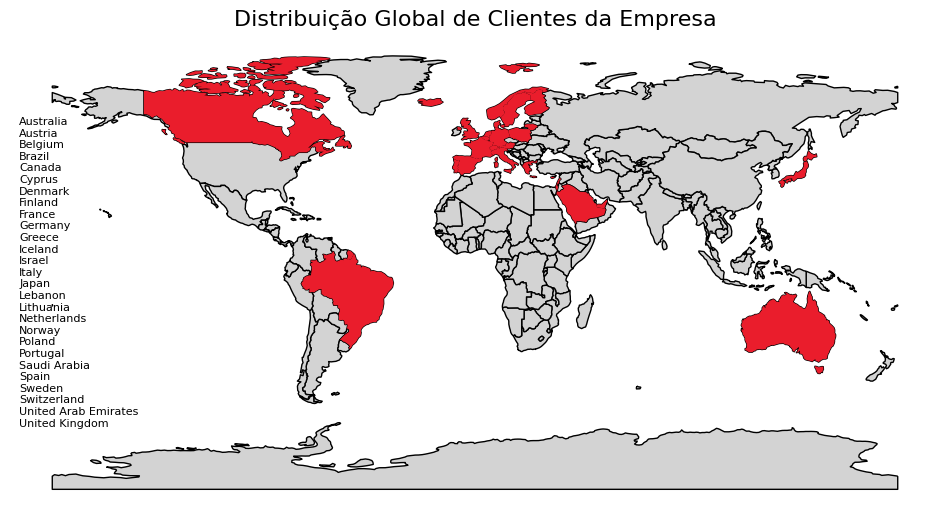

In [35]:
# Criando mapa
fig, ax = plt.subplots(figsize=(12, 8))
mundo.plot(ax=ax, color='lightgrey', edgecolor='black')
countries_to_plot.plot(ax=ax, color='#EA1D2C')

# Títulos  e legenda
ax.set_title('Distribuição Global de Clientes da Empresa', fontsize=16)
ax.set_xlabel('Comprimento', fontsize=12)
ax.set_ylabel('Altura', fontsize=12)
plt.axis('off')

# Legenda personalizada com os nomes dos países
legend_text = '\n'.join(countries_to_plot['name'])
legend = ax.text(0.01, 0.5, legend_text, fontsize=8, ha='left', va='center', color='black', transform=ax.transAxes)

Quantos países eles atendem?

In [36]:
print(f"A empresa atende {len(df_gold['País'].unique())} países.")

A empresa atende 37 países.


### <font color="#FFB761"> 2 - Quantos clientes eles possuem? </font>

In [37]:
num_clientes = len(df_gold['ID Cliente'].unique())
print(f"A empresa possui {num_clientes} clientes em todo o mundo.")

A empresa possui 4338 clientes em todo o mundo.


### <font color="#FFB761"> 3 - Quanto fatura em média (valor) por mês? </font>

A moeda utilizada pelo cliente é libras esterlinas.

In [38]:
faturamento_medio = sum(df_gold['Valor']/num_clientes)
print(f'O faturamento médio por mês da empresa é de {round(faturamento_medio, 2)} libras esterlinas.')

O faturamento médio por mês da empresa é de 2052.25 libras esterlinas.


### <font color="#FFB761"> 4 - Qual o mês que mais venderam (n° de faturas)? </font>

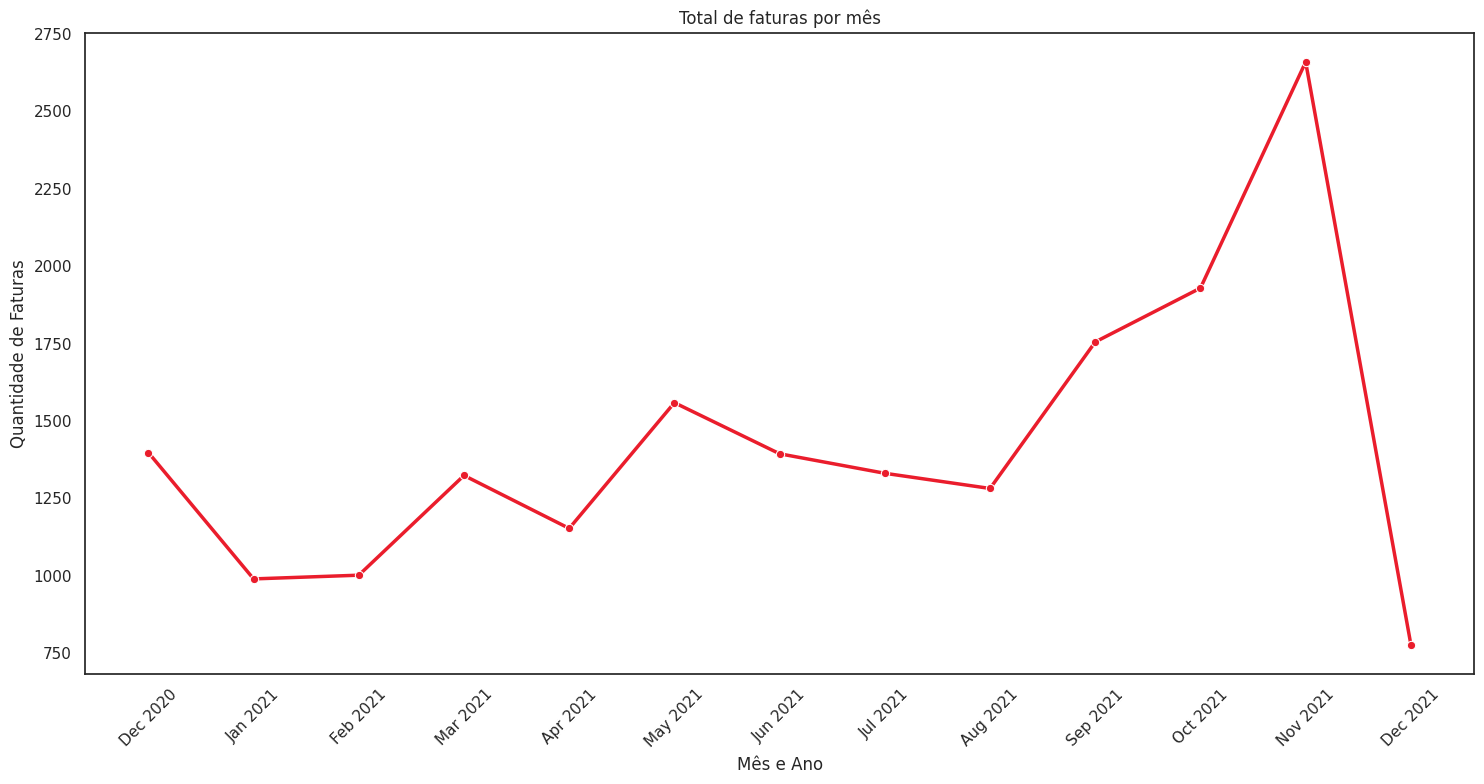

In [39]:
# Total de faturas por mês e ano
df_fatura_mes = pd.DataFrame(df_gold.groupby(pd.Grouper(key='Data da fatura', freq='M'))
                             ['N° da fatura'].count()).reset_index()
df_fatura_mes.rename(columns={"N° da fatura": "Quantidade_de_faturas"},
                     inplace=True)

df_fatura_mes['Data da fatura'] = pd.to_datetime(df_fatura_mes['Data da fatura'])

# Extraindo o mês e o ano da coluna "Data da fatura"
df_fatura_mes['Mês'] = df_fatura_mes['Data da fatura'].dt.month
df_fatura_mes['Ano'] = df_fatura_mes['Data da fatura'].dt.year

# Criando uma coluna para mês e ano para o eixo x
df_fatura_mes['Mês_Ano'] = df_fatura_mes['Data da fatura'].dt.strftime('%b %Y')

sns.set_theme(style="white", palette=None)
plt.figure(figsize=(15, 8))

ax = sns.lineplot(data=df_fatura_mes,
                  x="Mês_Ano",
                  y="Quantidade_de_faturas",
                  color='#EA1D2C',
                  linewidth=2.5,
                  marker="o")
ax.set_xlabel('Mês e Ano')
ax.set_ylabel('Quantidade de Faturas')
ax.set_title('Total de faturas por mês')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

In [40]:
print(f"Data da última venda no mês de Dezembro de 2021: {df_gold['Data da fatura'].iloc[-1]}")

Data da última venda no mês de Dezembro de 2021: 2021-12-09 12:50:00


Como pode ser observado no gráfico, o mês que apresentou maior número de vendas foi em **novembro de 2021**, o que contrasta com a enorme queda de Dezembro, mês em que ocorre o Natal. Porém, ainda estamos vendo os dados muito por cima. Vamos visualizar mais de perto e ver se isso condiz com o esperado para o mês de dezembro até a data do último registro.

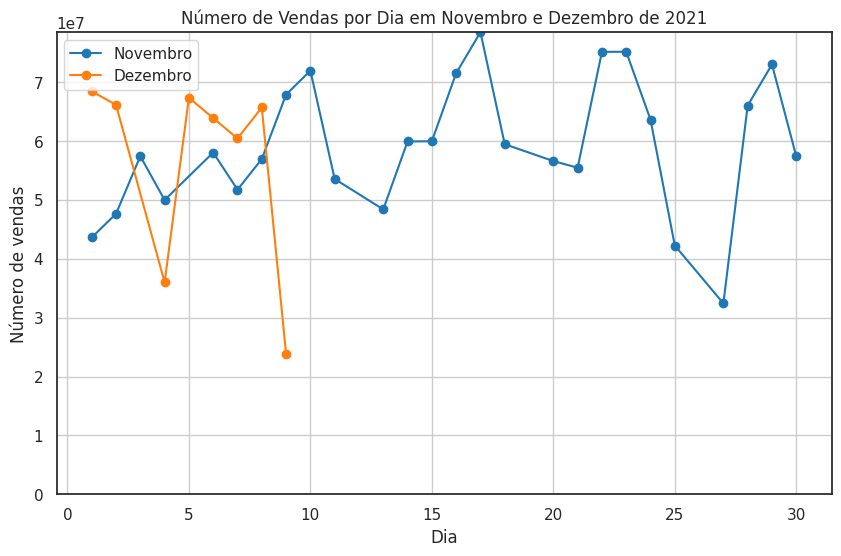

In [41]:
# Filtrando os dados para os meses de novembro e dezembro de 2021
df_filtered = df_gold[(df_gold['Data da fatura'] >= '2021-11-01') & (df_gold['Data da fatura'] <= '2021-12-31')]

# Extraindo dia e mês da coluna 'Data da fatura'
df_filtered['Dia'] = df_filtered['Data da fatura'].dt.day
df_filtered['Mês'] = df_filtered['Data da fatura'].dt.month

# Convertendo a coluna 'N° da fatura' para o tipo de dado numérico
df_filtered['N° da fatura'] = pd.to_numeric(df_filtered['N° da fatura'])

# Agrupando por dia a quantidade vendida
df_daily = df_filtered.groupby(['Mês', 'Dia'])['N° da fatura'].sum().reset_index()

# Encontrando o máximo de faturas vendidas por dia
max_faturas = df_daily['N° da fatura'].max()
plt.figure(figsize=(10, 6))

# Vendas em novembro
plt.plot(df_daily[df_daily['Mês'] == 11]['Dia'], df_daily[df_daily['Mês'] == 11]['N° da fatura'], marker='o', linestyle='-', label='Novembro')

# Vendas em dezembro
plt.plot(df_daily[df_daily['Mês'] == 12]['Dia'], df_daily[df_daily['Mês'] == 12]['N° da fatura'], marker='o', linestyle='-', label='Dezembro')

plt.xlabel('Dia')
plt.ylabel('Número de vendas')
plt.title('Número de Vendas por Dia em Novembro e Dezembro de 2021')
plt.legend()
plt.grid(True)

# Definindo o limite do eixo y como o máximo de faturas vendidas por dia
plt.ylim(0, max_faturas + 10)  # Adicionando uma margem de 10 para melhor visualização
plt.show()

Em relação ao mês de novembro, aos primeiros 09 dias do mês, dezembro apresenta um resultado melhor que novembro. Visto que durante esse período de tempo, o mês apresentou resultado inferior ao mês anterior apenas em um dia e meio (a coleta dos dados do dia 09 só possuem registro até o meio dia). Com base nisso, é possível afirmar que talvez o mês apresente resultado total superior ao mês onze.

### <font color="#FFB761"> 5 - Qual o mês que mais venderam (quantidade)? </font>

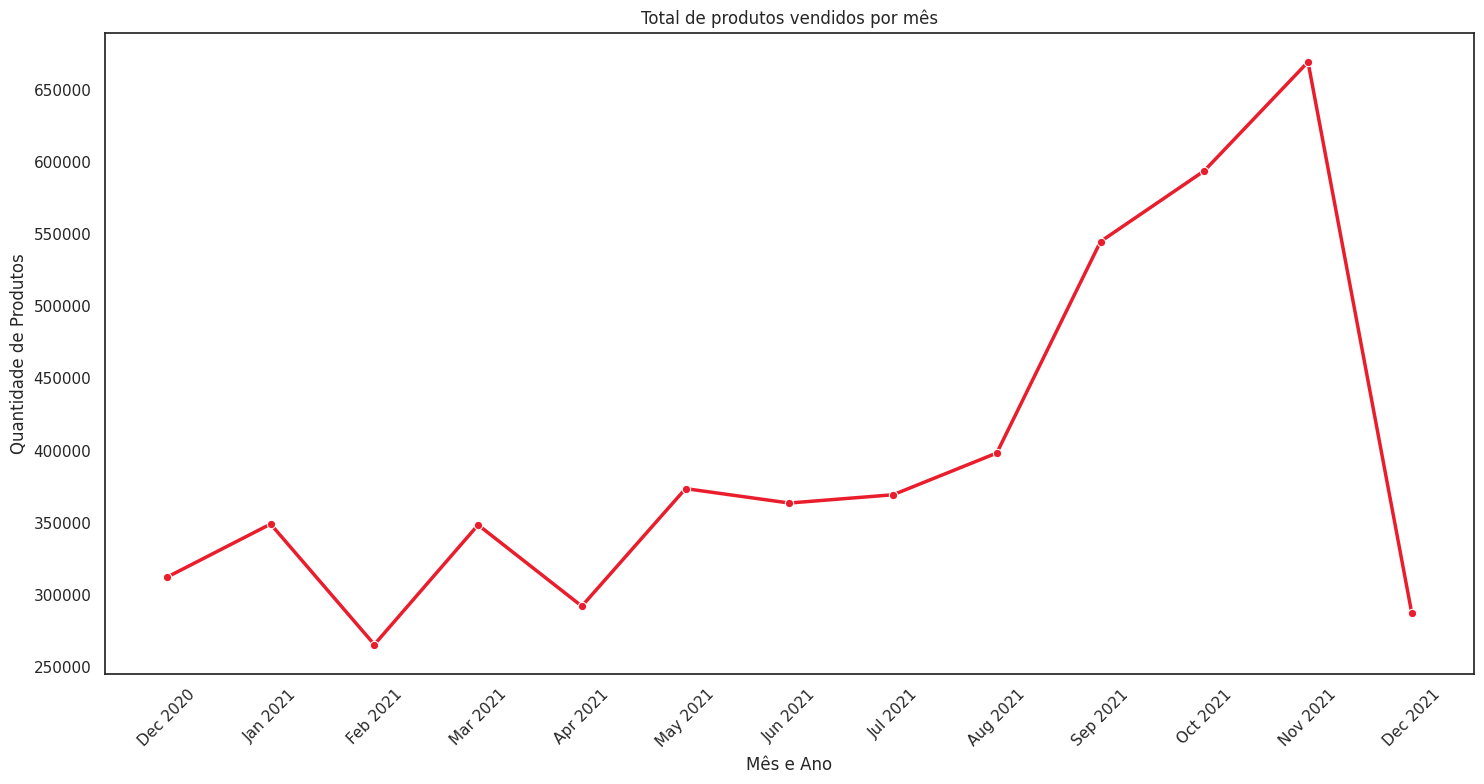

In [42]:
# Total de produtos por mês e ano
df_quant_mes = pd.DataFrame(df_gold.groupby(pd.Grouper(key='Data da fatura', freq='M'))
                             ['Quantidade'].sum()).reset_index()
df_quant_mes.rename(columns={"Quantidade": "Quantidade_de_produtos"},
                     inplace=True)

df_quant_mes['Data da fatura'] = pd.to_datetime(df_fatura_mes['Data da fatura'])

# Extraindo o mês e o ano da coluna "Data da fatura"
df_quant_mes['Mês'] = df_quant_mes['Data da fatura'].dt.month
df_quant_mes['Ano'] = df_quant_mes['Data da fatura'].dt.year

# Criando uma coluna para mês e ano para o eixo x
df_quant_mes['Mês_Ano'] = df_quant_mes['Data da fatura'].dt.strftime('%b %Y')

sns.set_theme(style="white", palette=None)
plt.figure(figsize=(15, 8))

ax = sns.lineplot(data=df_quant_mes,
                  x="Mês_Ano",
                  y="Quantidade_de_produtos",
                  color='#EA1D2C',
                  linewidth=2.5,
                  marker="o")
ax.set_xlabel('Mês e Ano')
ax.set_ylabel('Quantidade de Produtos')
ax.set_title('Total de produtos vendidos por mês')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

Assim como a quantidade de vendas, a quantidade de produtos vendidos também é maior em novembro.

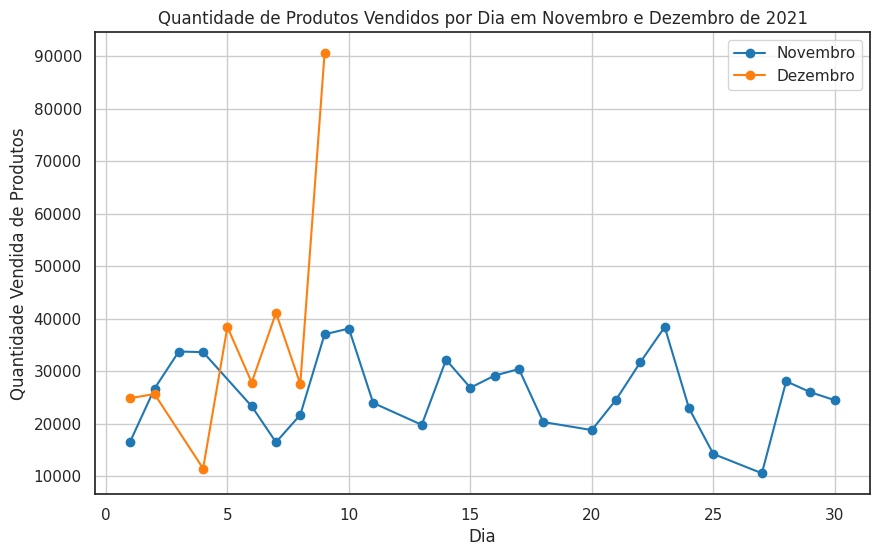

In [43]:
# Filtrando os dados para os meses de novembro e dezembro de 2021
df_filtered = df_gold[(df_gold['Data da fatura'] >= '2021-11-01') & (df_gold['Data da fatura'] <= '2021-12-31')]

# Extraindo dia, mês e ano da coluna 'Data da fatura'
df_filtered['Dia'] = df_filtered['Data da fatura'].dt.day
df_filtered['Mês'] = df_filtered['Data da fatura'].dt.month

# Agrupando por dia a quantidade vendida
df_daily = df_filtered.groupby(['Mês', 'Dia'])['Quantidade'].sum().reset_index()
plt.figure(figsize=(10, 6))

# Vendas em novembro
plt.plot(df_daily[df_daily['Mês'] == 11]['Dia'], df_daily[df_daily['Mês'] == 11]['Quantidade'], marker='o', linestyle='-', label='Novembro')

# Vendas em dezembro
plt.plot(df_daily[df_daily['Mês'] == 12]['Dia'], df_daily[df_daily['Mês'] == 12]['Quantidade'], marker='o', linestyle='-', label='Dezembro')

plt.xlabel('Dia')
plt.ylabel('Quantidade Vendida de Produtos')
plt.title('Quantidade de Produtos Vendidos por Dia em Novembro e Dezembro de 2021')
plt.legend()
plt.grid(True)
plt.show()

Apesar de vendo o geral o mês de dezembro parecer ruim, quando observado mais de perto é possível notar que ainda pode ser um mês muito promissor. E acabar sendo o mês com maior número de vendas ao longo não somente do ano, mas também de toda a história da empresa, que apresenta 1 ano e um mês de existência de acordo com os dados.

O mês de novembro pode estar indicando apenas o início de um final de ano muito positivo.

É válido lembrar que os dados nos informam as vendas até meio dia do dia 09. A não ser que seja um dia de trabalho meio período, é possível que a quantidade de produtos vendidos seja ainda maior.

### <font color="#FFB761"> 6 - Qual a média de venda (quantidade) e faturamento (valor) por país? </font>

In [44]:
# Calculando a média de venda por país
media_prod = df_gold['Quantidade'].sum()//len(df_gold['País'].unique())
print(f'A média de produtos vendidos por país é de {media_prod} unidades.')

A média de produtos vendidos por país é de 139690 unidades.


In [45]:
# Calculando a média de faturamento por país
media_fat = df_gold['Valor'].sum()//len(df_gold['País'].unique())
print(f'A média de faturamento por país é de {media_fat} libras esterlinas.')

A média de faturamento por país é de 240612.0 libras esterlinas.


### <font color="#FFB761"> 7 - Qual a média de venda (quantidade) e faturamento (valor) por cliente? </font>

In [46]:
# Calculando a média de venda por cliente
media_prod = df_gold['Quantidade'].sum()//len(df_gold['ID Cliente'].unique())
print(f'A média de produtos vendidos por cliente é de {media_prod} unidades.')

A média de produtos vendidos por cliente é de 1191 unidades.


In [47]:
# Calculando a média de faturamento por cliente
media_fat = df_gold['Valor'].sum()//len(df_gold['ID Cliente'].unique())
print(f'A média de faturamento por cliente é de {media_fat} libras esterlinas.')

A média de faturamento por cliente é de 2052.0 libras esterlinas.


### <font color="#FFB761"> 8 - Quantos clientes possuem mais de uma compra? </font>

In [48]:
# Identificando quantos clientes realizaram pelo menos duas compras
cli_recorr = df_gold['ID Cliente'].count() - df_gold['ID Cliente'].nunique()
cli_unicos = df_gold['ID Cliente'].nunique()

In [49]:
print(f'A empresa possui {cli_unicos} clientes que realizaram uma compra e {cli_recorr} clientes que fizeram mais de uma compra.')

A empresa possui 4338 clientes que realizaram uma compra e 14216 clientes que fizeram mais de uma compra.


### <font color="#FFB761"> 9 - Qual foi o cliente com maior volume de compras? </font>

In [51]:
clientes_volume = df_gold.copy()
clientes_volume.sort_values(by=['Quantidade'], ascending=False, inplace=True)
clientes_volume.head(10)

,N° da fatura,Data da fatura,ID Cliente,País,Quantidade,Valor
9437,581483,2021-12-09 09:15:00,16446.0,United Kingdom,80995,168469.0
10527,541431,2021-01-18 10:01:00,12346.0,United Kingdom,74215,77183.0
17557,556917,2021-06-15 13:37:00,12415.0,Australia,15049,22775.0
3926,563076,2021-08-11 16:12:00,14646.0,Netherlands,14730,19150.0
3262,572035,2021-10-20 12:03:00,14646.0,Netherlands,13392,20277.0
15261,567423,2021-09-20 11:05:00,17450.0,United Kingdom,12572,31698.0
12164,552883,2021-05-12 10:13:00,14646.0,Netherlands,12266,14415.0
11622,563614,2021-08-18 08:51:00,12415.0,Australia,12196,21880.0
13872,562439,2021-08-04 18:06:00,12931.0,United Kingdom,11848,18841.0
9718,548011,2021-03-29 11:14:00,14646.0,Netherlands,11116,15719.0


O cliente com maior volume de compras foi o 16446, que está localizado no Reino Unido.

### <font color="#FFB761"> 10 - Qual foi o cliente com maior gasto financeiro? </font>

In [52]:
clientes_fat = df_gold.copy()
clientes_fat.sort_values(by=['Valor'], ascending=False, inplace=True)
clientes_fat.head(10)

,N° da fatura,Data da fatura,ID Cliente,País,Quantidade,Valor
9437,581483,2021-12-09 09:15:00,16446.0,United Kingdom,80995,168469.0
10527,541431,2021-01-18 10:01:00,12346.0,United Kingdom,74215,77183.0
16715,556444,2021-06-10 15:28:00,15098.0,United Kingdom,60,38970.0
15261,567423,2021-09-20 11:05:00,17450.0,United Kingdom,12572,31698.0
17557,556917,2021-06-15 13:37:00,12415.0,Australia,15049,22775.0
18511,572209,2021-10-21 12:08:00,18102.0,United Kingdom,1920,22206.0
473,567381,2021-09-20 10:12:00,17450.0,United Kingdom,6760,22104.0
11622,563614,2021-08-18 08:51:00,12415.0,Australia,12196,21880.0
14171,550461,2021-04-18 13:20:00,15749.0,United Kingdom,9014,21535.0
3262,572035,2021-10-20 12:03:00,14646.0,Netherlands,13392,20277.0


O cliente que ofereceu maior faturamento foi também o 16446.

### <font color="#FFB761"> 11 - Horário do dia com maior fluxo/n° de vendas </font>

In [59]:
# Extraindo a hora do dia da coluna 'Data da fatura'
df_gold['Hora'] = df_gold['Data da fatura'].dt.hour

# Agrupar por hora do dia e calculando a contagem única de faturas
faturas_por_hora = df_gold.groupby('Hora')['N° da fatura'].nunique()

# Qual a hora com maior volume de vendas?
hora_maior_volume = faturas_por_hora.idxmax()
maior_volume = faturas_por_hora.max()

print("Horário com o maior volume de compras:", hora_maior_volume)
print("Maior volume de compras:", maior_volume)

Horário com o maior volume de compras: 12
Maior volume de compras: 3129


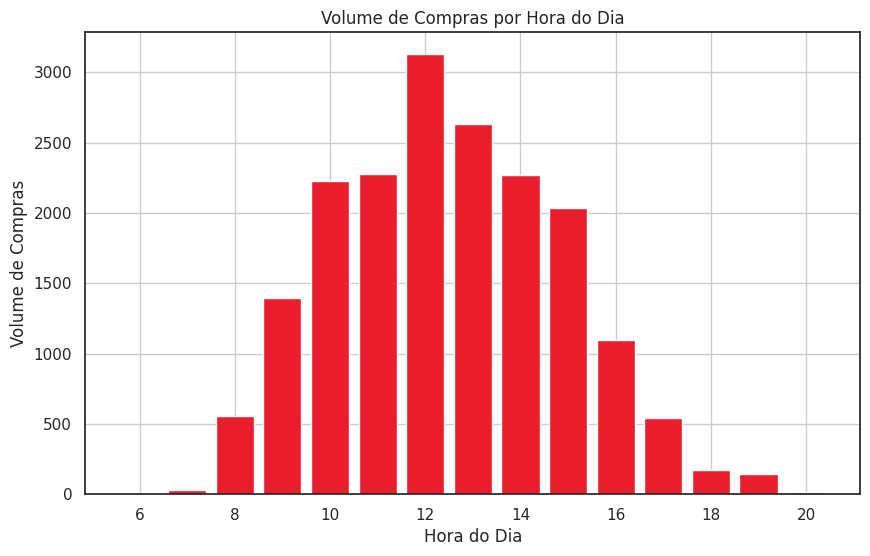

In [60]:
plt.figure(figsize=(10, 6))
plt.bar(faturas_por_hora.index, faturas_por_hora.values, color='#EA1D2C')
plt.xlabel('Hora do Dia')
plt.ylabel('Volume de Compras')
plt.title('Volume de Compras por Hora do Dia')
plt.grid(True)
plt.show()

Como pode ser observado, ao longo dos meses, o horário com maior volume de vendas é às 12h.

# Daqui em diante, parte do que foi desenvolvido pela INGRID

In [ ]:
# Selecionando apenas as colunas numérica
numeric_columns = df.select_dtypes(include=[np.number]).columns

# Percorrendo cada coluna numérica do DataFrame
for col in numeric_columns:
    print(f'Coluna: {col}')
    print(df[col].value_counts().iloc[:5])
    print('\n')

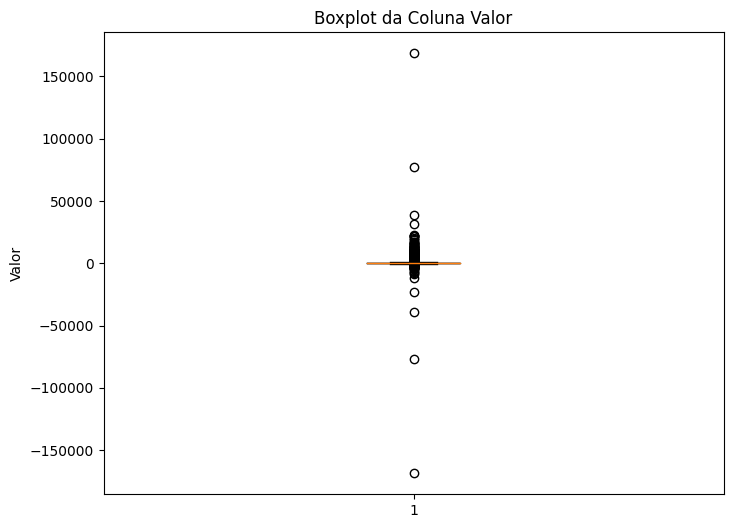

In [94]:
#  verificando outliers na coluna valor
plt.figure(figsize=(8,6))
plt.boxplot(df['Valor'])
plt.title('Boxplot da Coluna Valor')
plt.ylabel('Valor')
plt.show()

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22221 entries, 0 to 25951
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   N° da fatura    22221 non-null  object        
 1   Data da fatura  22221 non-null  datetime64[ns]
 2   ID Cliente      22221 non-null  float64       
 3   País            22221 non-null  object        
 4   Quantidade      22221 non-null  int64         
 5   Valor           22221 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 1.7+ MB


In [112]:
# Remover possíveis outliers no valor dos produtos vendidos
Q1 = df['Valor'].quantile(0.25)
Q3 = df['Valor'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['Valor'] >= lower_bound) & (df['Valor'] <= upper_bound)]

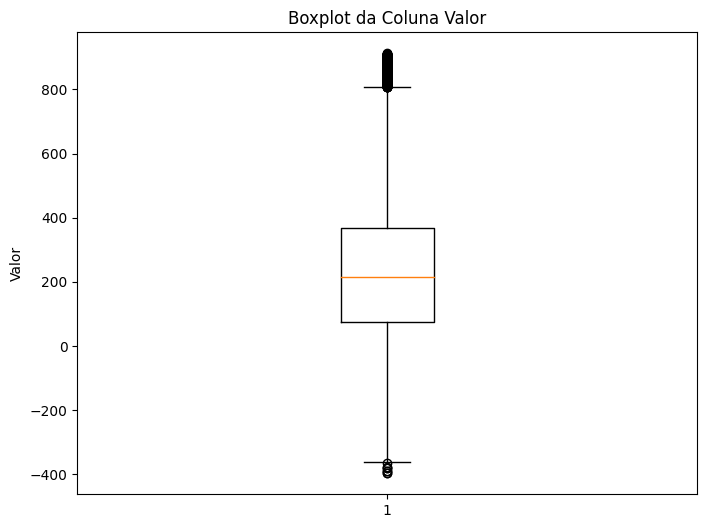

In [97]:
# EM ESTUDO
#  verificando outliers na coluna valor
plt.figure(figsize=(8,6))
plt.boxplot(df['Valor'])
plt.title('Boxplot da Coluna Valor')
plt.ylabel('Valor')
plt.show()

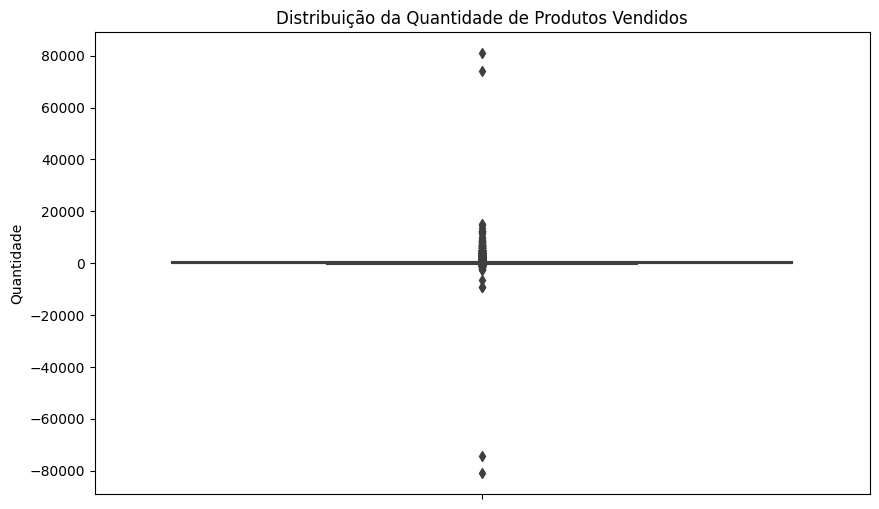

In [98]:
#  Distribuição da quantidade de produtos vendidos
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_base, y='Quantidade')
plt.title('Distribuição da Quantidade de Produtos Vendidos')
plt.ylabel('Quantidade')
plt.show()

In [113]:
# Remover possíveis outliers no valor dos produtos vendidos
Q1 = df['Quantidade'].quantile(0.25)
Q3 = df['Quantidade'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['Quantidade'] >= lower_bound) & (df['Quantidade'] <= upper_bound)]

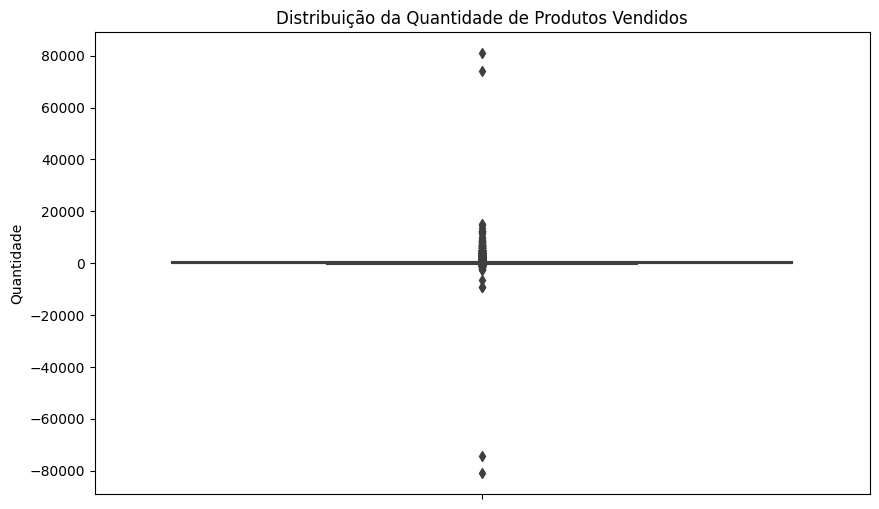

In [101]:
#  Distribuição da quantidade de produtos vendidos
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_base, y='Quantidade')
plt.title('Distribuição da Quantidade de Produtos Vendidos')
plt.ylabel('Quantidade')
plt.show()

In [114]:
df.describe()

,Data da fatura,ID Cliente,Quantidade,Valor
count,19851,19851.000000,19851.000000,19851.000000
mean,2021-06-28 12:13:34.517153024,15257.690746,129.524659,232.646815
min,2020-12-01 08:26:00,12347.000000,-264.000000,-396.960000
25%,2021-03-27 14:07:00,13767.000000,24.000000,67.745000
50%,2021-07-06 11:10:00,15172.000000,102.000000,207.600000
75%,2021-10-10 14:37:30,16767.000000,205.000000,353.490000
max,2021-12-09 12:50:00,18287.000000,509.000000,912.660000
std,NaN,1728.604631,126.341081,211.227412


In [124]:
# a dispersão e a forma da distribuição de um conjunto de dados, excluindo os valores NaN.
df_describe = df.describe()

# A amplitude é a diferença entre o valor máximo e mínimo.
df_describe.loc['amp'] = df_describe.loc['max'] - df_describe.loc['min']

# O coeficiente de variação (CV) é uma medida da variabilidade relativa em relação à média.
df_describe.loc['cv'] = (df_describe.loc['std'] / df_describe.loc['mean'] ).abs() *100

# A assimetria é uma medida estatística para avaliar a assimetria na distribuição dos dados.
df_describe.loc['skewness'] = df.skew()

# Calculando o IQR para cada coluna numérica
df_describe.loc['IQR'] = df_describe.loc['75%'] - df_describe.loc['25%']

# Por fim, o código arredonda os valores para duas casas decimais e transpõe o DataFrame para melhor visualização.
df_describe.round(2).T

TypeError: could not convert string to float: 'United Kingdom'

In [128]:
# Análise de valores negativos na coluna 'Valor'
valores_negativos = df[df['Valor'].replace(',', '').astype(float) < 0]
print("\nNúmero de transações com valores negativos:", len(valores_negativos))
print("Exemplo de transações com valores negativos:\n")
valores_negativos.head()


Número de transações com valores negativos: 3501
Exemplo de transações com valores negativos:



,N° da fatura,Data da fatura,ID Cliente,País,Quantidade,Valor
2,570727,2021-10-12 11:32:00,12471.0,Germany,-1,-1.45
10,543628,2021-02-10 15:51:00,16558.0,United Kingdom,-5,-9.25
17,553508,2021-05-17 13:44:00,14000.0,United Kingdom,-3,-1.95
20,577693,2021-11-21 11:48:00,12628.0,Germany,-3,-16.85
22,547309,2021-03-22 11:17:00,17416.0,United Kingdom,-12,-45.00


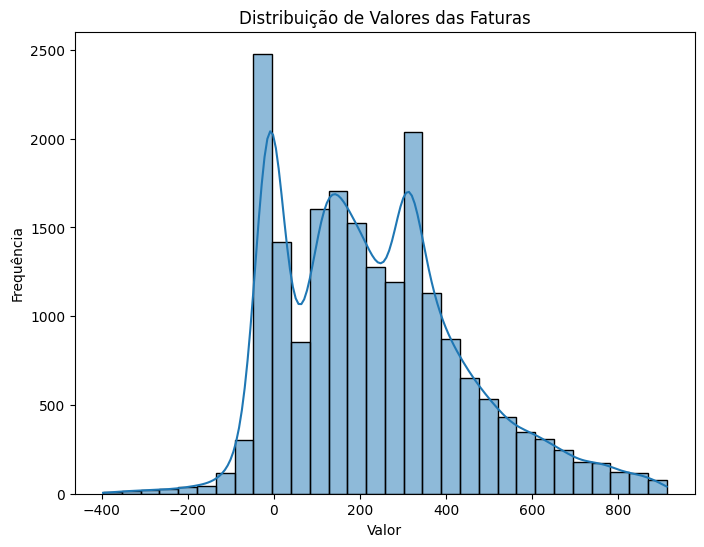

In [129]:
# Distribuição de valores das faturas
plt.figure(figsize=(8, 6))
sns.histplot(df['Valor'], bins=30, kde=True)
plt.title('Distribuição de Valores das Faturas')
plt.xlabel('Valor')
plt.ylabel('Frequência')
plt.show()

In [136]:
# Explorar correlações entre variáveis numéricas
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlação')
plt.show()

AttributeError: 'Index' object has no attribute 'corr'

<Figure size 1000x800 with 0 Axes>

In [33]:
indices_para_remover = df_base[df_base['N° da fatura'].str.startswith('C')].index

In [34]:
# Remover as linhas identificadas
df = df_base.drop(indices_para_remover)

In [35]:
# Exibir o DataFrame sem as linhas que começam com a letra "C"
df.head()

,N° da fatura,Data da fatura,ID Cliente,País,Quantidade,Valor
0,548370,3/30/2021 16:14:00,15528.0,United Kingdom,123,"229,33"
1,575767,11/11/2021 11:11:00,17348.0,United Kingdom,163,"209,73"
3,549106,4/6/2021 12:08:00,17045.0,United Kingdom,1,"39,95"
4,573112,10/27/2021 15:33:00,16416.0,United Kingdom,357,"344,83"
5,576630,11/16/2021 8:38:00,13816.0,Germany,91,"199,98"


In [36]:
df.shape

(18566, 6)

In [62]:
#Extraindo estatiticas
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID Cliente,18570.0,15265.970813,1734.016581,12346.0,13772.5,15173.0,16779.0,18287.0
Quantidade,22112.0,246.683475,930.773561,-9600.0,48.0,133.0,274.0,80995.0


In [63]:
df.nunique()

N° da fatura      22064
Data da fatura    19990
ID Cliente         4339
País                 38
Quantidade         1783
Valor             15846
dtype: int64

In [58]:
# Selecionando apenas as colunas numérica
numeric_columns = df.select_dtypes(include=[np.number]).columns

# Percorrendo cada coluna numérica do DataFrame
for col in numeric_columns:
    print(f'Coluna: {col}')
    print(df[col].value_counts().iloc[:5])
    print('\n')

Coluna: ID Cliente
12748.0    212
14911.0    203
17841.0    124
13089.0     97
14606.0     95
Name: ID Cliente, dtype: int64


Coluna: Quantidade
1     502
2     262
12    219
24    203
4     179
Name: Quantidade, dtype: int64




In [71]:
# Visualizar estatísticas descritivas
print(df_base.describe())

         ID Cliente    Quantidade
count  20696.000000  20696.000000
mean   15246.108717    140.894859
std     1729.984621    141.853286
min    12347.000000   -300.000000
25%    13758.750000     24.000000
50%    15152.000000    108.000000
75%    16748.500000    218.000000
max    18287.000000    590.000000


In [72]:
# a dispersão e a forma da distribuição de um conjunto de dados, excluindo os valores NaN.
df_describe = df_base.describe()

# A amplitude é a diferença entre o valor máximo e mínimo.
df_describe.loc['amp'] = df_describe.loc['max'] - df_describe.loc['min']

# O coeficiente de variação (CV) é uma medida da variabilidade relativa em relação à média.
df_describe.loc['cv'] = (df_describe.loc['std'] / df_describe.loc['mean'] ).abs() *100

# A assimetria é uma medida estatística para avaliar a assimetria na distribuição dos dados.
df_describe.loc['skewness'] = df_base.skew()

# Calculando o IQR para cada coluna numérica
df_describe.loc['IQR'] = df_describe.loc['75%'] - df_describe.loc['25%']

# Por fim, o código arredonda os valores para duas casas decimais e transpõe o DataFrame para melhor visualização.
df_describe.round(2).T

,count,mean,std,min,25%,50%,75%,max,amp,cv,skewness,IQR
ID Cliente,20696.0,15246.11,1729.98,12347.0,13758.75,15152.0,16748.5,18287.0,5940.0,11.35,0.06,2989.75
Quantidade,20696.0,140.89,141.85,-300.0,24.00,108.0,218.0,590.0,890.0,100.68,0.94,194.00


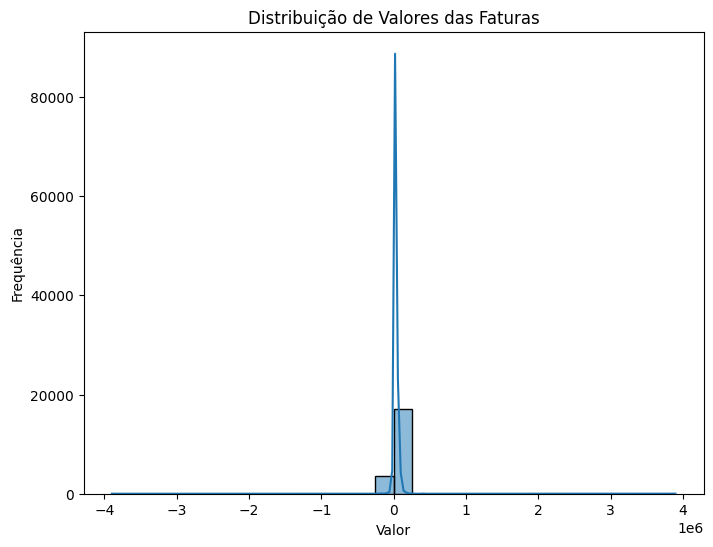

In [83]:
# Distribuição de valores das faturas
plt.figure(figsize=(8, 6))
sns.histplot(df_base['Valor'].str.replace(',', '').astype(float), bins=30, kde=True)
plt.title('Distribuição de Valores das Faturas')
plt.xlabel('Valor')
plt.ylabel('Frequência')
plt.show()

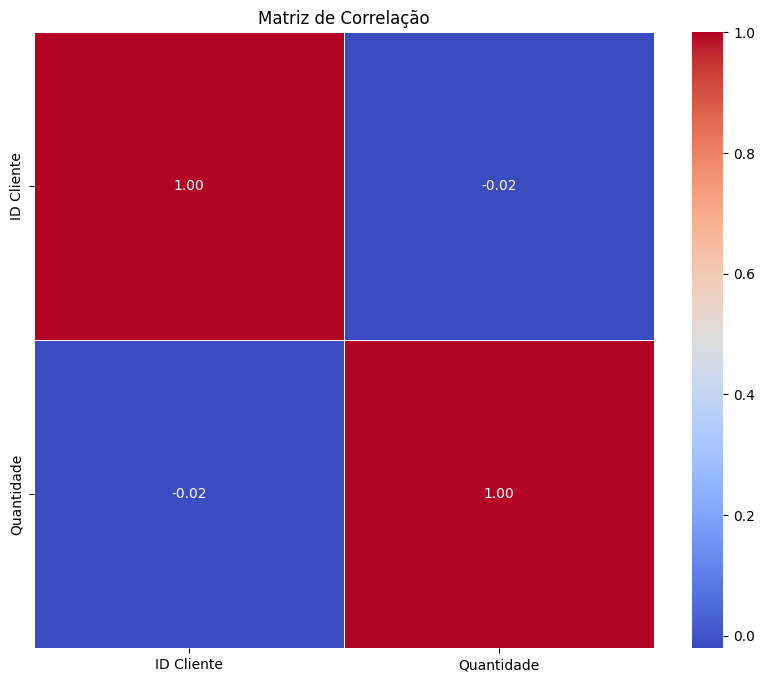

In [65]:
# Explorar correlações entre variáveis numéricas
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlação')
plt.show()

In [77]:
# Sgmentos de clientes mais lucrativos
top_clientes = df_base['ID Cliente'].value_counts().nlargest(10)
print("\nTop 10 Clientes com mais transações:")
print(top_clientes)



Top 10 Clientes com mais transações:
12748.0    217
14911.0    205
17841.0    167
14606.0    130
13089.0    103
15311.0    102
14527.0     86
12971.0     86
13408.0     80
16029.0     61
Name: ID Cliente, dtype: int64


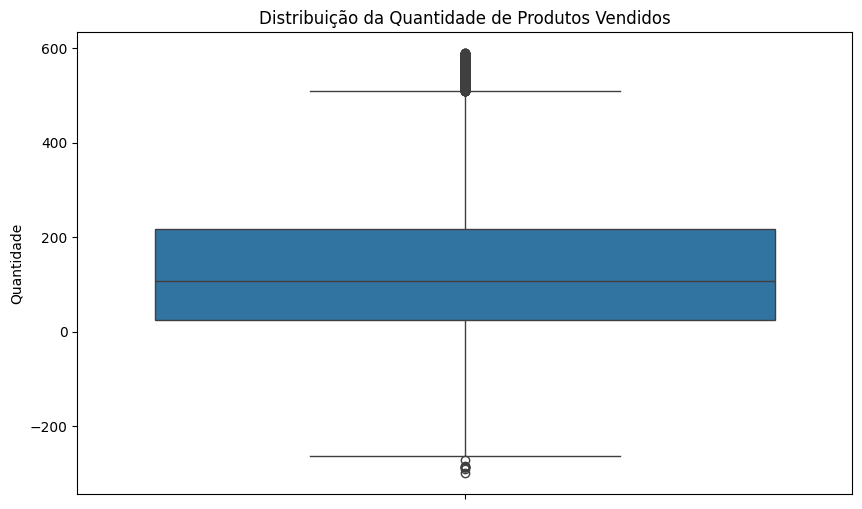

In [76]:
#  Distribuição da quantidade de produtos vendidos
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_base, y='Quantidade')
plt.title('Distribuição da Quantidade de Produtos Vendidos')
plt.ylabel('Quantidade')
plt.show()